# Scoring experiments #

### Start with imports: ###

In [101]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from urllib.request import urlopen

from ipywidgets import IntProgress
from IPython.display import display
import time

from scipy.optimize import minimize
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from pprint import pprint

   ### Load data: ###

In [102]:
dataurl  = "https://github.com/aalto-speech/interspeech2019_karhila_et_al/blob/master/phone_recognition_results_v0.21.pickle?raw=true"
[phones, phones_to_features, hypotheses, references, scores, speakers, words, train_speakers, test_speakers] = pickle.load(urlopen(dataurl))

### Define weighted Levenshtein distance ###

This is modified by Reima Karhila from https://github.com/infoscout/weighted-levenshtein to produce a list of edit operations. 

In [103]:
def levenshtein_edit_ops(arr1, arr2, insert_costs=None,delete_costs=None,substitute_costs=None):
    """
    Calculates the Levenshtein distance between str1 and str2,
    provided the costs of inserting, deleting, and substituting characters.
    The costs default to 1 if not provided.

    """

    # Some special cases we wouldn't like to see:
    if len(arr1) == 0 and len(arr2) == 0:
        print("arr1 and arr2 zero length, returning cost and ops:", 0, [])
        return 0, []

    elif len(arr2) == 0:
        path = [ ['d', i, i ] for i in arr2 ]
        if delete_costs is not None:
            ret_val = sum( [ delete_costs[i] for i in arr1 ] )
        else:
            ret_val = len(arr1)
        print("arr2 zero length, returning cost and ops:", ret_val, path)
        return ret_val, path

    elif len(arr1) == 0:
        path = [ ['i', i, i ] for i in arr1 ]
        if insert_costs is not None:
            ret_val = sum( [ insertion_costs[i] for i in arr2 ] )
        else:
            ret_val = len(arr2)
        print("arr1 zero length, returning cost and ops:", ret_val, path)
        return ret_val, path

    maxchar = max( max(arr1), max(arr2) )
    
    if insert_costs is None:
        insert_costs = np.ones([ maxchar+1 ])
    if delete_costs is None:
        delete_costs = np.ones([ maxchar+1 ])
    if substitute_costs is None:
        #print("Using default substitute costs")
        substitute_costs = np.ones([ maxchar+1,maxchar+1 ])


    s1 = [-1] + arr1
    s2 = [-1] + arr2

    len1 = len(s1)
    len2 = len(s2)
    
    op_ident = 0.0
    op_ins = 1.0
    op_del = 2.0
    op_sub = 3.0

    d = np.zeros([len1, len2], dtype=np.float32)
    editops = np.zeros([len1,len2, 3], dtype=np.int)

    d[0,0] = 0
    char_i = s1[0]
    char_j = s2[0]
        
    for i in range(1, len1 ):
        char_i = s1[i]
        d[i,0] = d[i-1,0] + delete_costs[char_i]
        editops[i,0] = [op_del, char_i, -1]
        
    for j in range(1, len2):
        char_j = s2[j]
        #print( d[0,j-1], insert_costs[char_j])
        d[0,j] = d[0,j-1] + insert_costs[char_j]
        editops[0,j] = [op_ins, char_j, -1]
        
    for i in range(1, len1 ):
        char_i = s1[i]
        for j in range(1, len2):
            char_j = s2[j]
            #print(char_i,char_j)
            if char_i == char_j:  # match
                d[i,j] = d[i-1,j-1]
                editops[i,j,:] = [op_ident, char_i, char_j]
            else:
                delcost = d[i-1,j] + delete_costs[char_i]
                inscost = d[i,j-1] + insert_costs[char_j]
                subcost = d[i-1,j-1] + substitute_costs[char_i, char_j]
                
                if delcost < inscost and delcost < subcost:
                    d[i,j] = delcost
                    editops[i,j,:] = [op_del, char_i, -1]
                elif inscost < delcost and inscost < subcost:
                    d[i,j] = inscost
                    editops[i,j,:] = [op_ins, char_j, -1]
                else:
                    d[i,j] = subcost
                    editops[i,j,:] = [op_sub, char_i, char_j]

    ret_val = d[len1-1,len2-1]

    i = len1-1
    j = len2-1
    path = []
    while i > 0 or j > 0:        
        op = editops[i,j,:]
        if op[0] == op_sub:
            path.append( ['s', op[1], op[2] ] )
            i = i-1
            j = j-1
        elif op[0] == op_ins:
            path.append( ['i', op[1], op[2] ] )
            j = j-1
        elif op[0] == op_del:
            path.append( ['d', op[1], op[2] ] )
            i = i-1
        elif op[0] == op_ident:
            i = i-1
            j = j-1
        
    return ret_val, path

### Helper data structures ###

In [104]:
classes = {}
for i,p in phones.items():
    classes[p] = i

features = {}
for feats in phones_to_features.values():
    for feat in feats:
        if feat not in features.keys():
            features[feat] = len(features.keys())

phonetype_counts = { 'consonant' : {}, 'vowel' : {}, 'nonspeech': {} }
phone_stats = np.zeros([len(phones), len(features)])

mean_num_features_per_phone = 0
for p,feats in phones_to_features.items():
    if p in classes.keys():
        if 'vowel' in feats:
            ptype = 'vowel'
        elif 'consonant' in feats:
            ptype = 'consonant'
        else:
            ptype = 'nonspeech'
        for feat in feats:
            mean_num_features_per_phone += 1
            phonetype_counts[ptype][feat] = 1
            phone_stats[classes[p],features[feat]] = 1
        
mean_num_features_per_phone /= len(phones)

### Phone Clustering Dendogram ###

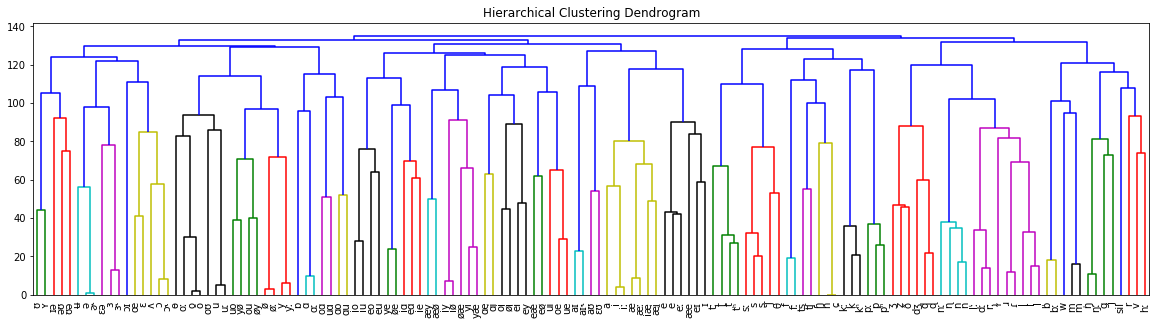

In [105]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_
    
    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])
    
    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)
    
    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
clustering = AgglomerativeClustering(n_clusters=len(phones))
clustering.fit(phone_stats)


plt.rcParams['figure.figsize'] = [20, 5]
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, labels=[ u''+i for i in phones.values()], leaf_font_size=10)
plt.show()


### Initial phone distances ###

And also a matrix for phone differences

In [106]:
phone_distances = np.zeros( [len(phones),len(phones)])

for i in range(len(phones)):
    for j in range(len(phones)):
        if i == j:
            continue
        if i > j:
            continue
        p1 = phones_to_features[phones[i]]
        p2 = phones_to_features[phones[j]]
        if ('vowel' in p1 and 'vowel') in p2 or ('consonant' in p1 and 'consonant' in p2):
            d = 0
            for a in p1:
                if a not in p2:
                    d += 1
            for a in p2:
                if a not in p1:
                    d += 1
            if 'consonant' in p1:
                dist = (d)/len(phonetype_counts['consonant'])
            else:
                dist = (d)/len(phonetype_counts['vowel'])
        else:
            dist = 1
        phone_distances [i][j] = dist
        phone_distances [j][i] = dist
        
phone_differences =  np.zeros( [len(phones),len(phones), len(features) + 1 ] )
phone_feat_vectors = np.zeros( [len(phones), len(features)] )

for i in range(len(phones)):
    p1 = phones_to_features[phones[i]]
    v1 = np.zeros([len(features) + 1])
    for feat in p1:
        v1[features[feat]] += 1 
    phone_feat_vectors[i,:] = v1[:-1]
    for j in range(len(phones)):
        if i >= j:
            continue
        p2 = phones_to_features[phones[j]]
        v2 = np.zeros([len(features) + 1])
        if ('vowel' in p1 and 'vowel') in p2 or ('consonant' in p1 and 'consonant' in p2):
            for feat in p2:
                v2[features[feat]] += 1
            diffv = np.logical_xor(v1,v2)
        else:
            diffv = np.zeros( [len(features) + 1] )
            diffv[-1] = 1
        phone_differences[i,j,:] = diffv
        phone_differences[j,i,:] = diffv

### Initial costvectors ###

In [107]:
sub_costvector =  np.zeros( [len(features) + 1] )
for ptype in ['consonant', 'vowel']:
    for k in phonetype_counts[ptype].keys():
        sub_costvector[features[k]] = 1/len(phonetype_counts[ptype])

sub_costvector[-1] = 1    
ins_costvector = np.ones([len(features)]) / mean_num_features_per_phone
del_costvector = np.ones([len(features)]) / mean_num_features_per_phone


sub_costmatrix = phone_differences.dot(sub_costvector)
ins_costmatrix = phone_feat_vectors.dot(ins_costvector)
del_costmatrix = phone_feat_vectors.dot(del_costvector)

### Split the data and create observation matrices with initial best paths ###

- Take approx 10% of train data to be our devel set
- We'll be using the training data twice: Once with the correct reference and score, and another time with a random reference and a rejection score
- The little progress indicator is from https://stackoverflow.com/a/41457700

In [108]:
train_items = np.zeros(len(speakers), dtype=np.bool)
devel_items = np.zeros(len(speakers), dtype=np.bool)
test_items = np.zeros(len(speakers), dtype=np.bool)

for i in range(len(speakers)):
    if speakers[i] in test_speakers:
        test_items[i] = True
    elif i% 10 == 0:
        devel_items[i] = True
    else:
        train_items[i] = True

        
refmap = np.arange(0, len(speakers)+train_items.sum())
refmap[len(speakers):] = np.random.permutation(np.where(train_items==True)[0])

# Duplicate training data:
devel_items = np.hstack([devel_items, np.zeros(train_items.sum()).astype(np.bool)])
test_items = np.hstack([test_items, np.zeros(train_items.sum()).astype(np.bool)])
train_items = np.hstack([train_items, np.ones(train_items.sum()).astype(np.bool)])




nO_sub = np.zeros( [len(refmap), len(hypotheses[0]), sub_costvector.shape[0]] , dtype=np.int8 )
nO_del = np.zeros( [len(refmap), len(hypotheses[0]), del_costvector.shape[0]] , dtype=np.int8 )
nO_ins = np.zeros( [len(refmap), len(hypotheses[0]), ins_costvector.shape[0]] , dtype=np.int8 )

least_err_indices =  np.zeros( len(refmap), dtype=np.int8 )
ref_lengths = np.zeros( len(refmap), dtype=np.int8 )
perfects = -np.ones( len(refmap), dtype=np.int8 )

print("Refmap size:", len(refmap))

print("Train items:", train_items.sum())
print(" Test items:", test_items.sum())
print("Devel items:", devel_items.sum())

print("Devel items intersect train items",len(np.intersect1d(np.where(devel_items==True)[0],np.where(train_items==True)[0])))
print(" Test items intersect train items",len(np.intersect1d(np.where(test_items==True)[0],np.where(train_items==True)[0])))


Refmap size: 29882
Train items: 24236
 Test items: 4313
Devel items: 1333
Devel items intersect train items 0
 Test items intersect train items 0


In [109]:


for j in range(len(refmap)):
    refseq = references[refmap[j]]
    besterr = np.inf
    bestindex = 0
    ref_lengths[j] = len(refseq)
    if len(refseq)>0:
        for i in range(len(hypotheses[0])):
            hypseq = hypotheses[ j % len(hypotheses) ][i].tolist()
            nO_sub[j,i,:] = 0
            nO_del[j,i,:] = 0
            nO_ins[j,i,:] = 0
            if len(hypseq)>0:
                #print( ''.join([phones[k] for k in hypseq ]) )
                cost,eops = levenshtein_edit_ops(refseq, hypseq,
                                                 substitute_costs=sub_costmatrix,
                                                 insert_costs=ins_costmatrix,
                                                 delete_costs=del_costmatrix)
                for op in eops:
                    #print(op)
                    if op[0] == 's':
                        nO_sub[j,i,:] += phone_differences[op[1],op[2],:].astype(np.int8)
                    elif op[0] == 'd':
                        nO_del[j,i,:] += phone_feat_vectors[op[1],:].astype(np.int8)
                    elif op[0] == 'i':
                        nO_ins[j,i,:] += phone_feat_vectors[op[1],:].astype(np.int8)                                            
                cost = cost/len(refseq)
                if cost < besterr:
                    bestindex = i
                    besterr = cost
                    besthyp = hypseq
                    if len(eops) == 0:
                        perfects[j] = bestindex
            else:
                for r in refseq:
                    nO_ins[j,i,:] += phone_feat_vectors[r,:].astype(np.int8)    
        if j == 0:
            print("Ref",'\t', "Path", "\t", "Error", '\t', "Reference".ljust(20), '     ', "Best hypothesis" )
        if j < 20:
            print ( j, '\t', bestindex,'\t',"%0.2f"%besterr,'\t',''.join([phones[k] for k in refseq ]).ljust(20),' ==> ',''.join([phones[k] for k in besthyp ]))
        elif j == 20:
            print("")
            print("This is pretty slow - No multi-threading, no Cython libraries etc.")
            print("So let's use a progress bar to check how we are doing in processing %i samples." % len(refmap))
            f = IntProgress(min=0, max=len(refmap)) # instantiate the bar
            f.value = 20
            display(f) # display the bar
        else:
            f.value += 1
        least_err_indices[j] = bestindex

print("Done! Yey!")

Ref 	 Path 	 Error 	 Reference                  Best hypothesis
0 	 9 	 0.54 	 lʌv                   ==>  iloːva
1 	 17 	 0.06 	 ðɪs                   ==>  ðiːs
2 	 30 	 0.22 	 kwaɪət                ==>  haɪət
3 	 43 	 0.23 	 fiːɫd                 ==>  fɹd
4 	 10 	 0.25 	 maθs                  ==>  nts
5 	 25 	 0.25 	 bɔɪ                   ==>  hu
6 	 26 	 0.41 	 kʰeɪk                 ==>  pk
7 	 15 	 0.04 	 ɹɪvəɹ                 ==>  ɹɪvəs
8 	 0 	 0.00 	 ləʊ                   ==>  ləʊ
9 	 23 	 0.00 	 meɪk                  ==>  meɪk
10 	 17 	 0.00 	 ʃiːp                  ==>  ʃiːp
11 	 23 	 0.34 	 θaŋkjuː               ==>  lantsiːz
12 	 48 	 0.24 	 wɛɫdʌn                ==>  ɹngɒn
13 	 35 	 0.38 	 jʊəɹəp                ==>  reulu
14 	 25 	 0.28 	 θaŋkjuː               ==>  ɪksju
15 	 40 	 0.32 	 bʊk                   ==>  lk
16 	 24 	 0.22 	 θɪŋ                   ==>  sɪŋə
17 	 31 	 0.04 	 kʰaɹət                ==>  kʰadətʃ
18 	 9 	 0.18 	 ʃəʊɫdəɹ               ==>  səʊɫda
19 	 42 	 0

IntProgress(value=20, max=29882)

Done! Yey!


### Scores ###

In [110]:
scores = scores[:len(speakers)]
inv_scores = np.zeros(len(refmap))
inv_scores[:len(scores)] = (100-scores)/100
inv_scores[len(scores):] = 1.01

### Optimisation ###

In [111]:
O_sub = np.zeros( [len(refmap), sub_costvector.shape[0]] , dtype=np.int8 )
O_ins = np.zeros( [len(refmap), ins_costvector.shape[0]] , dtype=np.int8 )
O_del = np.zeros( [len(refmap), del_costvector.shape[0]] , dtype=np.int8 )

sub_indices=np.arange(0, len(sub_costvector), dtype=int)
ins_indices=np.arange(max(sub_indices)+1, max(sub_indices)+1+len(ins_costvector), dtype=int)
del_indices=np.arange(max(ins_indices)+1, max(ins_indices)+1+len(del_costvector), dtype=int)
warping_index = np.max(del_indices)+1
length_compensation_index = np.max(warping_index)+1

x0 = np.zeros([length_compensation_index+1])
x0[sub_indices] = sub_costvector
x0[ins_indices] = ins_costvector
x0[del_indices] = del_costvector
x0[warping_index] = 1
x0[length_compensation_index] = 1

current_train_items = train_items

def tanh(x,a, scale=1.01):
    return scale * (np.tanh(a*x))

def get_error_rates(hypx, items):
    return O_sub[items].dot(hypx[sub_indices]) + O_ins[items].dot(hypx[ins_indices]) + O_del[items].dot(hypx[del_indices])

def do_computation(hypx, items):
    hyp_scores = get_error_rates(hypx, items)
    hyp_scores /=  (ref_lengths[items] ** hypx[length_compensation_index])
    hyp_scores = tanh(hyp_scores, hypx[warping_index])
    return hyp_scores

def costfunction(hypx):    
    hyp_scores = do_computation(hypx, current_train_items)
    # Normal least squares:
    # np.mean( (hyp_scores - inv_scores[current_train_items])**2)
    # Cauchy norm to limit outlier influence:
    return np.mean( (np.log(1.01 + np.abs(hyp_scores - inv_scores[current_train_items])))**2)

def get_scores(hypx, items):
    return 100-(do_computation(hypx, items)*100)


def compute_Os(hypx, nbest_mult):
    for i in range(len(refmap)):
        num_nbest = np.clip( nbest_mult * ref_lengths[i], 1, len(hypotheses[ i % len(speakers) ]))
        least_err_indices[i] = np.argmin( nO_sub[i,:num_nbest,:].dot(hypx[sub_indices]) + \
                                          nO_ins[i,:num_nbest,:].dot(hypx[ins_indices]) + \
                                          nO_del[i,:num_nbest,:].dot(hypx[del_indices]) )
        O_sub[i,:] = nO_sub [i,least_err_indices[i],:]
        O_ins[i,:] = nO_ins [i,least_err_indices[i],:]
        O_del[i,:] = nO_del [i,least_err_indices[i],:]
        if train_items[i] and (O_sub[i,:].sum() > 0 or O_del[i,:].sum() == 0):
            current_train_items[i] = True
        else:
            current_train_items[i] = False


# Data-Driven Phoneme Weighted Levenshtein Distance #

In [112]:
bounds=[[0.02,1.5]]*(len(x0)) 
bounds[sub_indices[-1]] = [1.0,5.0] # change between vowel and consonant
#bounds[insert_indices[-1]] = [1.5,5] # change between vowel and consonant
#bounds[delete_indices[-1]] = [1.5,5] # change between vowel and consonant

bounds[warping_index] = [0.05,5] # warping index
bounds[length_compensation_index] = [0.1,3] # length compensation index

dd_wpld_xs = {}
dd_wpld_dev_scores = {}

nbest_multipliers = [0, 5, 10, 15, 50]
num_iter_rounds = 10
f = IntProgress(min=0, max=len(nbest_multipliers) * num_iter_rounds) # instantiate the bar
f.value = 0
print("Search for optimal parameters with different N-best list lengths")
display(f) # display the bar

for n in range(len(nbest_multipliers)):
    nbest_multiplier = nbest_multipliers[n]
    current_train_items = np.copy((train_items).astype(np.bool))
    x1 = 0.4*np.random.rand( x0.shape[0] ) + 0.1
    x2 = {'success' : False}
    dd_wpld_xs[nbest_multiplier] = {}
    dd_wpld_dev_scores[nbest_multiplier] = {} 
    #print("N-best hypotheses: %iL" % nbest_multiplier)
    for iterround in range(num_iter_rounds):
        f.value += 1        
        compute_Os(x1, nbest_multiplier)
        #print("             Optimisation round %i" % (iterround))
        x2 = minimize(costfunction, x1, bounds=bounds, options={'disp': False, 'maxiter': 19})
        x1 = x2['x']
        dd_wpld_xs[nbest_multiplier][iterround] = x1
        dd_wpld_hyp = get_scores(x1, devel_items)
        dd_wpld_dev_scores[nbest_multiplier][iterround] = np.corrcoef(scores[devel_items[:len(scores)]], dd_wpld_hyp)[0,1]
        #print("                         Score on dev set: %0.4f" % dd_wpld_dev_scores[nbest_multiplier][iterround])
        if x2['success']:
            break
        if iterround > 1:
            if dd_wpld_dev_scores[nbest_multiplier][iterround] < dd_wpld_dev_scores[nbest_multiplier][iterround-1]:
                #print("It's not getting better so breaking.")
                break
    f.value = num_iter_rounds * (n+1)
#print("Results on devel set:")
#pprint(dd_wpld_dev_scores)
          
          
print("")
ddwpld_best_score = -np.inf
ddwpld_best_system = None
best_keys = None
for k in dd_wpld_dev_scores.keys():
    for i in dd_wpld_dev_scores[k].keys():
        if dd_wpld_dev_scores[k][i] > ddwpld_best_score:
            ddwpld_best_score = dd_wpld_dev_scores[k][i]            
            ddwpld_best_system = dd_wpld_xs[k][i]
            best_keys = [k,i]
print("dd-wpld best score:",ddwpld_best_score)
print("dd-wpld best keys:", best_keys)

Search for optimal parameters with different N-best list lengths


IntProgress(value=0, max=50)


dd-wpld best score: 0.45792060118623173
dd-wpld best keys: [10, 2]


From the 5 runs, I got:

* 0.51_ on n-best list of 10/reference phone and 3 iterations
* 0.456 on full 51-best list and 7 iterations
* 0.458 on n-best list of 10/reference phone and 2 iterations

What did you get?

# Basic Phoneme Weighted Levenshtein Distance #

Here we take the phoneme weights as granted and optimise only the mapping parameters.

In [113]:

bounds=np.zeros([len(x0),2]) 
bounds[sub_indices,0] = sub_costvector
bounds[sub_indices,1] = sub_costvector
bounds[ins_indices,0] = ins_costvector
bounds[ins_indices,1] = ins_costvector
bounds[del_indices,0] = del_costvector
bounds[del_indices,1] = del_costvector
bounds[warping_index] = [0.05,15] # warping index
bounds[length_compensation_index] = [0.1,3] # length compensation index

base_wpld_xs = {}
base_wpld_dev_scores = {}

f = IntProgress(min=0, max=len(nbest_multipliers) * num_iter_rounds) # instantiate the bar
f.value = 0
print("Search for optimal parameters with different N-best list lengths")
display(f) # display the bar


for n in range(len(nbest_multipliers)):
    nbest_multiplier = nbest_multipliers[n]
    current_train_items = np.copy((train_items+1).astype(np.bool))
    x1 = 0.4*np.random.rand( x0.shape[0] ) + 0.1
    x2 = {'success' : False}
    base_wpld_xs[nbest_multiplier] = {}
    base_wpld_dev_scores[nbest_multiplier] = {} 
    #print("N-best hypotheses: %iL" % nbest_multiplier) 
    for iterround in range(10):
        f.value += 1         
        compute_Os(x0, nbest_multiplier)
        #print("             Optimisation round %i" % (iterround))
        x2 = minimize(costfunction, x1, bounds=bounds, options={'disp': True, 'maxiter': 29})
        x1 = x2['x']
        base_wpld_xs[nbest_multiplier][iterround] = x1
        base_wpld_hyp = get_scores(x1, devel_items)
        base_wpld_dev_scores[nbest_multiplier][iterround] = np.corrcoef(scores[devel_items[:len(scores)]], base_wpld_hyp)[0,1]
        #print("                         Score on dev set: %0.4f" % base_wpld_dev_scores[nbest_multiplier][iterround])
        if x2['success']:
            break
        if iterround > 1:
            if base_wpld_dev_scores[nbest_multiplier][iterround] < base_wpld_dev_scores[nbest_multiplier][iterround-1]:
                #print("It's not getting better so breaking.")
                break
    f.value = num_iter_rounds * (n+1)
                
#print("Results on devel set:")
#pprint(base_wpld_dev_scores)
          
print("Done! Yey!")                    
          
print("")
basewpld_best_score = -np.inf
basewpld_best_system = None
basewpld_best_keys = None
for k in base_wpld_dev_scores.keys():
    for i in base_wpld_dev_scores[k].keys():
        if base_wpld_dev_scores[k][i] > basewpld_best_score:
            basewpld_best_score = base_wpld_dev_scores[k][i]            
            basewpld_best_system = base_wpld_xs[k][i]
            basewpld_best_keys = [k,i]
print("Base-pwld best score:",basewpld_best_score)
print("Base-pwld best keys:", basewpld_best_keys)

Search for optimal parameters with different N-best list lengths


IntProgress(value=0, max=50)

Done! Yey!

Base-pwld best score: 0.417294859589439
Base-pwld best keys: [50, 0]


On the 5 runs, I got the best scores 

* 0.417, using the whole 51-best list.
* 0.417, using the whole 51-best list.
* 0.417, using the whole 51-best list.



# Regression with Support Vector Machines and Random Forests #

In [114]:

svm_xs = {}
svm_dev_scores = {}
max_iter = 10000


cs =  [1,  100, 400]
epsilons = [0.01, 0.1, 0.2, 0.5]

f = IntProgress(min=0, max=len(nbest_multipliers) * len(cs) * len(epsilons)) # instantiate the bar
f.value = 0
print("Grid search for optimal parameters with different N-best list lengths and C and Epsilon values")
display(f) # display the bar

for nbest_multiplier in [0, 5, 10, 15, 50]:
    compute_Os(x0, nbest_multiplier)
    parameterisation_for_svm = np.hstack([ref_lengths.reshape([-1,1]) ,O_sub, O_ins, O_del])
    svm_xs[nbest_multiplier] = {}
    svm_dev_scores[nbest_multiplier] = {}    
    for c in cs:
        svm_xs[nbest_multiplier][c] = {}
        svm_dev_scores[nbest_multiplier][c] = {}
        for epsilon in epsilons:
            f.value += 1
            #print("Training SVR with nbest_multiplier=%i C=%0.1f, epsilon=%0.3f" % (nbest_multiplier,c, epsilon))
            svm_xs[nbest_multiplier][c][epsilon] = SVR(epsilon=epsilon, C=c, kernel='rbf', degree=3, coef0=0.0, shrinking=True, tol=0.001, cache_size=200, verbose=False, max_iter = max_iter)
            svm_xs[nbest_multiplier][c][epsilon].fit( parameterisation_for_svm[current_train_items,:], inv_scores[current_train_items])
            svm_hyp = svm_xs[nbest_multiplier][c][epsilon].predict( parameterisation_for_svm[devel_items,:])
            svm_dev_scores[nbest_multiplier][c][epsilon] = np.corrcoef(svm_hyp, inv_scores[devel_items])[0,1]
            #print("Correlation with devel set: %0.3f" % svm_dev_scores[nbest_multiplier][c][epsilon])
print ("Done, yey!")

Grid search for optimal parameters with different N-best list lengths and C and Epsilon values


IntProgress(value=0, max=60)

/l/rkarhila/scratch/conda-envs/tf.1.13.1_nogpu/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Done, yey!


In [115]:
print("")
svm_best_score = -np.inf
svm_best_system = None
svm_best_keys = None
for k in svm_dev_scores.keys():
    for i in svm_dev_scores[k].keys():
        for j in svm_dev_scores[k][i].keys():
            if svm_dev_scores[k][i][j] > svm_best_score:
                svm_best_score = svm_dev_scores[k][i][j]
                svm_best_system = svm_xs[k][i][j]
                svm_best_keys = [k,i,j]
print("SVM best score:",svm_best_score)
print("SVM best keys:", svm_best_keys)



SVM best score: 0.4907249296868968
SVM best keys: [10, 1, 0.2]


Wow, that took some time! Grid searching is certainly not optimal but you can't say I didn't put effort in these "competing technologies"...

Anyway, numbers on the 5 runs: 

* 0.496 for n-best list of 5/reference phone, C 100 and epsilon 0.2 (!).
* 0.489 for n-best list of 10/reference phone, C 1 and epsilon 0.2 (!).
* 0.491 for n-best list of 10/reference phone, C 1 and epsilon 0.2 (!).

In [116]:
rf_xs = {}
rf_dev_scores = {}

f = IntProgress(min=0, max=len(nbest_multipliers) * len(cs) * len(epsilons)) # instantiate the bar
f.value = 0
print("Grid search for optimal parameters with different N-best list lengths and estimator and min sample values")
display(f) # display the bar
n_ests = [20, 100,  400]
min_sampleses = [1, 10, 20]

for nbest_multiplier in nbest_multipliers:
    compute_Os(x0, nbest_multiplier)
    parameterisation_for_svm = np.hstack([ref_lengths.reshape([-1,1]) ,O_sub, O_ins, O_del])    
    rf_xs[nbest_multiplier] = {}
    rf_dev_scores[nbest_multiplier] = {}
    for n_est in n_ests:
        rf_xs[nbest_multiplier][n_est] = {}
        rf_dev_scores[nbest_multiplier][n_est] = {}
        for min_samples in min_sampleses:
            f.value += 1
            #print("Training random forest with nbest_multiplier=%i number of estimators=%i, min_sample_for_leaf=%i" % (nbest_multiplier, n_est, min_samples))
            #rf_xs[n_est][min_samples] = RandomForestRegressor(n_estimators=n_est, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=1, warm_start=False)
            rf_xs[nbest_multiplier][n_est][min_samples] = RandomForestRegressor(n_estimators=n_est, criterion='mse', min_samples_split=2, min_samples_leaf=min_samples, verbose=0)
            rf_xs[nbest_multiplier][n_est][min_samples].fit( parameterisation_for_svm[current_train_items,:], inv_scores[current_train_items])
            rf_hyp = rf_xs[nbest_multiplier][n_est][min_samples].predict( parameterisation_for_svm[devel_items,:])
            rf_dev_scores[nbest_multiplier][n_est][min_samples] = np.corrcoef(rf_hyp, inv_scores[devel_items])[0,1]
            #print("Correlation with devel set: %0.3f" % rf_dev_scores[nbest_multiplier][c][epsilon])
       
print ("Done, yey!")

Grid search for optimal parameters with different N-best list lengths and estimator and min sample values


IntProgress(value=0, max=60)

Done, yey!


In [117]:
print("")
rf_best_score = -np.inf
rf_best_system = None
rf_best_keys = None
for k in rf_dev_scores.keys():
    for i in rf_dev_scores[k].keys():
        for j in rf_dev_scores[k][i].keys():
            if rf_dev_scores[k][i][j] > rf_best_score:
                rf_best_score = rf_dev_scores[k][i][j]
                rf_best_system = rf_xs[k][i][j]
                rf_best_keys = [k,i,j]
print("Random Forest best score:",rf_best_score)
print("Random Forest best keys:", rf_best_keys)


Random Forest best score: 0.5034383906578757
Random Forest best keys: [50, 100, 10]


Whoa! 

I got 

* 0.494 with n-best list of 5/reference phone, 100 estimators and leaf minimum size of 1.
* 0.502 with the full 51-best list, 400 estimators and minimun leaf size of 1
* 0.503 with the full 51-best list, 100 estimators and minimun leaf size of 10

# Comparison of systems #

In [118]:
compute_Os(ddwpld_best_system, 10) #ddwpld_best_keys[0])
dd_wpld_test_scores = do_computation(ddwpld_best_system, test_items )

compute_Os(basewpld_best_system, basewpld_best_keys[0])
base_wpld_test_scores = do_computation(basewpld_best_system, test_items )


compute_Os(x0, svm_best_keys[0])
parameterisation_for_svm = np.hstack([ref_lengths.reshape([-1,1]) ,O_sub, O_ins, O_del])
svm_test_scores = svm_best_system.predict( parameterisation_for_svm[test_items,:])

compute_Os(x0, rf_best_keys[0])
parameterisation_for_svm = np.hstack([ref_lengths.reshape([-1,1]) ,O_sub, O_ins, O_del])
rf_test_scores = rf_best_system.predict( parameterisation_for_svm[test_items,:])

    


In [119]:
ref_test_scores = inv_scores[test_items]

correlations = { 'rf' : np.corrcoef(rf_test_scores, ref_test_scores)[0,1],
                 'svm' : np.corrcoef(svm_test_scores, ref_test_scores)[0,1],
                 'ddwlpd' : np.corrcoef(dd_wpld_test_scores, ref_test_scores)[0,1],
                 'basewlpd' : np.corrcoef(base_wpld_test_scores, ref_test_scores)[0,1]}

error_vecs = { 'svm': np.abs(svm_test_scores*100-ref_test_scores),
                'rf': np.abs(rf_test_scores*100-ref_test_scores),
                'ddwpld' : np.abs(dd_wpld_test_scores-ref_test_scores),
                'basewlpd' : np.abs(base_wpld_test_scores - ref_test_scores) }

mean_errors = { 'svm': np.mean(error_vecs['svm']),
                'rf':  np.mean(error_vecs['rf']),
                'ddwpld' : np.mean(error_vecs['ddwpld']),
                'basewlpd' : np.mean(error_vecs['basewlpd']) }

error_std = { 'svm': np.std(error_vecs['svm']),
                'rf':  np.std(error_vecs['rf']),
                'ddwpld' : np.std(error_vecs['ddwpld']),
                'basewlpd' : np.std(error_vecs['basewlpd']) }


outliers =  {'svm': np.where(error_vecs['svm']> mean_errors['svm']+2*error_std['svm'])[0],
            'rf':  np.where(error_vecs['rf']> mean_errors['rf']+2*error_std['rf'])[0],
            'ddwpld' : np.where(error_vecs['ddwpld']> mean_errors['ddwpld']+2*error_std['ddwpld'])[0],
            'basewlpd' : np.where(error_vecs['basewlpd']> mean_errors['basewlpd']+2*error_std['basewlpd'])[0]}


non_outliers_voted = np.where(np.bincount(np.hstack([outliers['svm'],outliers['rf'],outliers['ddwpld'],outliers['basewlpd']])) <= 1)[0]
#non_outliers_voted = np.where(np.bincount(np.hstack([outliers['svm'],outliers['rf'],outliers['ddwpld'],outliers['basewpld']])) <= 0)[0]


correlations_outliers_removed = {
    'rf' :np.corrcoef(rf_test_scores[non_outliers_voted], ref_test_scores[non_outliers_voted]) [0,1],
    'svm' : np.corrcoef(svm_test_scores[non_outliers_voted], ref_test_scores[non_outliers_voted]) [0,1],
    'ddwlpd' : np.corrcoef(dd_wpld_test_scores[non_outliers_voted], ref_test_scores[non_outliers_voted]) [0,1],
    'basewlpd' : np.corrcoef(base_wpld_test_scores[non_outliers_voted], ref_test_scores[non_outliers_voted]) [0,1],}



In [120]:
print("Correlations for all test data:")
for k,v in correlations.items():
    print(k.ljust(15),"%0.3f"%v)
print("Correlations for test data where outliers are removed:")
for k,v in correlations_outliers_removed.items():
    print(k.ljust(15),"%0.3f"%v)

Correlations for all test data:
rf              0.509
svm             0.517
ddwlpd          0.475
basewlpd        0.426
Correlations for test data where outliers are removed:
rf              0.553
svm             0.568
ddwlpd          0.527
basewlpd        0.476


On the first run I got:
    
Correlations for all test data:

* rf           0.496, 0.512, 0.509
* svm           0.459, 0.521, 0.517
* ddwlpd          0.478, 0.470, 0.475
* basewlpd        0.426, 0.427, 0.425


Correlations for test data where outliers are removed:

* rf              0.537, 0.554, 0.553
* svm             0.474, 0.570, 0.568
* ddwlpd          0.547, 0.521, 0.527
* basewlpd        0.469, 0.476, 0.476



In [121]:
print(len(non_outliers_voted))
print(test_items.sum())
error_std

4198
4313


{'svm': 22.9864379350438,
 'rf': 23.360209473501804,
 'ddwpld': 0.21250628045270625,
 'basewlpd': 0.2440076002961799}

In [122]:
print("Train items:", current_train_items.sum())
print(" Test items:", test_items.sum())
print("Devel items:", devel_items.sum())

print("Devel item intersect current train items",len(np.intersect1d(np.where(devel_items==True)[0],np.where(current_train_items==True)[0])))
print(" Test item intersect current train items",len(np.intersect1d(np.where(test_items==True)[0],np.where(current_train_items==True)[0])))

Train items: 23440
 Test items: 4313
Devel items: 1333
Devel item intersect current train items 0
 Test item intersect current train items 0


In [123]:
# Check once more that we have not messed up our data:

print("Refmap size:", len(refmap))

print("Train items:", train_items.sum())
print(" Test items:", test_items.sum())
print("Devel items:", devel_items.sum())

print("Devel items intersect train items",len(np.intersect1d(np.where(devel_items==True)[0],np.where(train_items==True)[0])))
print(" Test items intersect train items",len(np.intersect1d(np.where(test_items==True)[0],np.where(train_items==True)[0])))

bins = np.bincount(refmap)
print("Count of items in refmap:", bins.shape[0])
print("Train items in refmap:", np.bincount(refmap[train_items]).sum())
print(" Test items in refmap:", np.bincount(refmap[test_items]).sum())
print("Devel items in refmap:", np.bincount(refmap[devel_items]).sum())



Refmap size: 29882
Train items: 24236
 Test items: 4313
Devel items: 1333
Devel items intersect train items 0
 Test items intersect train items 0
Count of items in refmap: 17764
Train items in refmap: 24236
 Test items in refmap: 4313
Devel items in refmap: 1333
